<h1>Building a movie content based recommender using tf-idf</h1>

# Types of recommender systems


* **Content-Based**: Content based recommenders will instead use data exclusively about the items. For this we need to have a minimal understanding of the users’ preferences, so that we can then recommend new items with similar tags/keywords to those specified (or inferred) by the user.

# The MovieLens Dataset

We used **MovieLents** dataset to test our recommender systems which contains rating data sets from the MovieLens web site.

# Data Preparation

In [14]:
# import need library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
from wordcloud import WordCloud

In [15]:
# load data

ratings = pd.read_csv('data_set/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])
users = pd.read_csv('data_set/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
movies = pd.read_csv('data_set/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

rating file:

In [16]:
ratings.shape

(1000209, 3)

In [17]:
ratings.sample(5)

,user_id,movie_id,rating
820646,4933,357,4
629078,3808,2268,3
330363,1950,780,2
219136,1329,441,1
145877,937,165,4


movies file:

In [18]:
movies.shape

(3883, 3)

In [19]:
movies.sample(5)

,movie_id,title,genres
2604,2673,Eternity and a Day (Mia eoniotita ke mia mera ...,Drama
2153,2222,Champagne (1928),Comedy
3824,3894,Solas (1999),Drama
374,378,Speechless (1994),Comedy|Romance
2959,3028,"Taming of the Shrew, The (1967)",Comedy


users file:


In [20]:
users.shape

(6040, 5)

In [21]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


# Data Exploration
### Ratings

Next I want to examine the rating further. One important aspect to consider is the distribution of the user ratings:

<Axes: xlabel='rating', ylabel='count'>

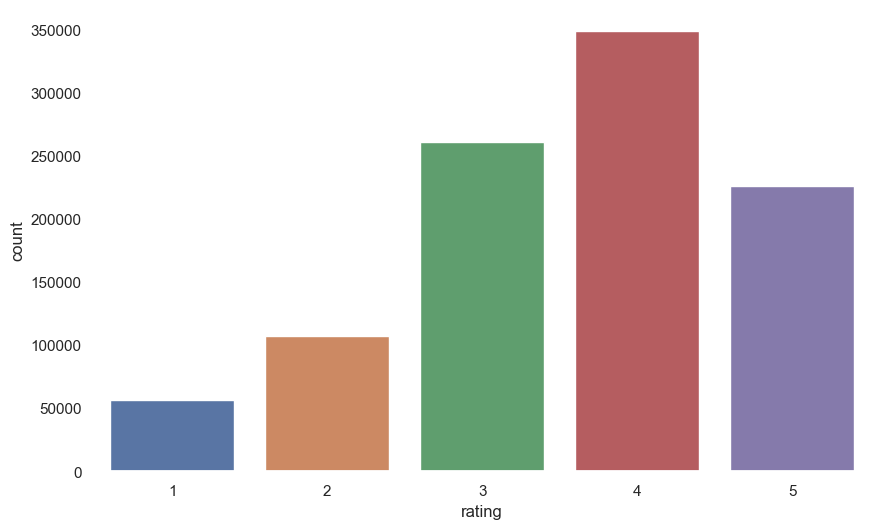

In [22]:
plt.figure(figsize=(10,6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

sns.countplot(data=ratings, x=ratings['rating'].fillna(ratings['rating'].median()))

* Which are the most popular movies?


We can take a weighted score taking into account both the ratings and the amount of views to answer this question:

In [23]:
def weighted_average_score(df, k=0.8):
    n_views = df.groupby('movie_id', sort=False).movie_id.count()
    ratings = df.groupby('movie_id', sort=False).rating.mean()
    scores = ((1-k)*(n_views/n_views.max()) + 
              k*(ratings/ratings.max())).to_numpy().argsort()[::-1]
    df_deduped = df.groupby('movie_id', sort=False).agg({'title':'first',
                                                         'genres':'first',
                                                         'rating':'mean'})
    return df_deduped.assign(views=n_views).iloc[scores]

In [24]:
df = movies.merge(ratings).merge(users)
weighted_average_score(df).head(10)

,title,genres,rating,views
movie_id,,,,
2858,American Beauty (1999),Comedy|Drama,4.317386,3428
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.453694,2991
1198,Raiders of the Lost Ark (1981),Action|Adventure,4.477725,2514
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,4.292977,2990
318,"Shawshank Redemption, The (1994)",Drama,4.554558,2227
527,Schindler's List (1993),Drama|War,4.510417,2304
858,"Godfather, The (1972)",Action|Crime|Drama,4.524966,2223
2028,Saving Private Ryan (1998),Action|Drama|War,4.337354,2653
2762,"Sixth Sense, The (1999)",Thriller,4.406263,2459


### Genres

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

* Which are the most popular genres?

This will be a relevant aspect to take into account when building the content based recommender. We want to understand which genres really are relevant when it comes to defining a user's taste. A reasonable assumption is that it is precisely the unpopular genres, that will be more relevant in characterising the user's taste.

The most relevant genres are:

In [25]:
genre_popularity = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

Drama         1603
Comedy        1200
Action         503
Thriller       492
Romance        471
Horror         343
Adventure      283
Sci-Fi         276
Children's     251
Crime          211
Name: genres, dtype: int64

Or for a more visual representation we could plot a word-cloud with the genres:

(-0.5, 999.5, 399.5, -0.5)

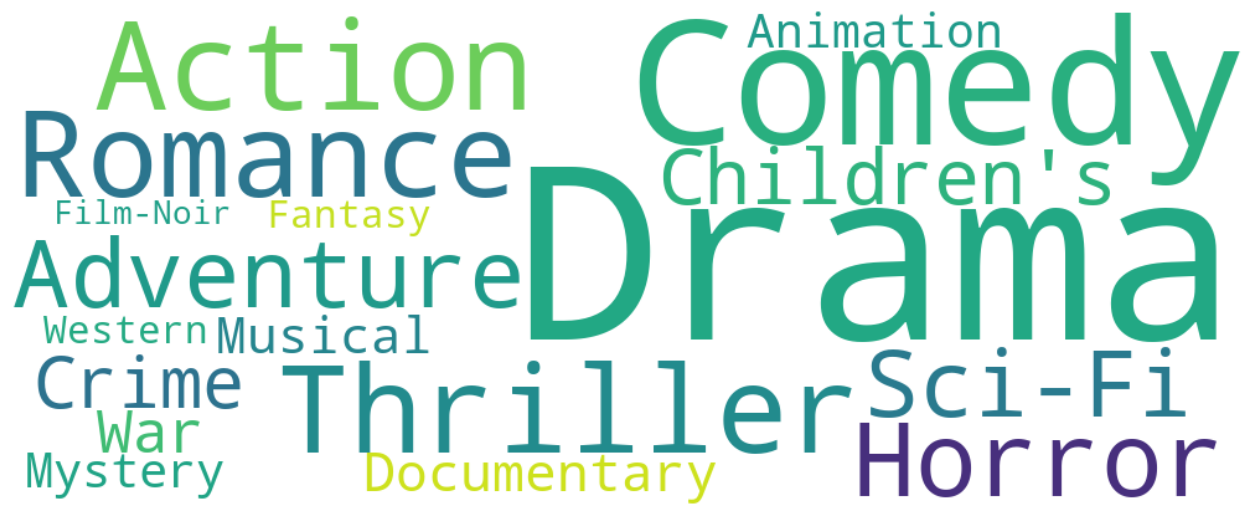

In [26]:
from wordcloud import WordCloud

genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

## Building a content based recommender